In [14]:
# import library
from sklearn.model_selection import train_test_split
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install nltk
from nltk.tokenize import word_tokenize, punkt, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus.reader import wordnet
from nltk.stem import WordNetLemmatizer
import re

In [15]:
# mount/load google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# mengubah dataset menjadi panda dataframe
df = pd.read_csv('/content/drive/MyDrive/Datasets/bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [17]:
# jumlah sampel data
len(df)

2225

In [18]:
# one hot encoding
category = pd.get_dummies(df['category'])
# menggabungkan hasil one hot encoding dan menghapus kolom label awal
df = pd.concat([df, category], axis=1)
df = df.drop(columns='category')

df.head()

,text,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0,0,0


In [19]:
def stop_words_removal(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    stop_words = set(stopwords.words('english'))
    removed_stop_words = [word.lower() for word in tokens if word.lower() not in stop_words]
    return ' '.join(removed_stop_words)

# menghapus stop words dari df
df['filtered_text'] = df['text'].apply(stop_words_removal)

def lemmatization(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_words)
# melakukan teknik lemma ke df
df['filtered_text'] = df['filtered_text'].apply(lemmatization)

def remove_number(text):
    text_without_numbers = re.sub(r'\d+', '', text)
    return text_without_numbers
# menghapus angka-angka dari df
df['filtered_text'] = df['filtered_text'].apply(remove_number)

df = df.drop(columns='text')
df.head()

,business,entertainment,politics,sport,tech,filtered_text
0,0,0,0,0,1,tv future hand viewer home theatre system plas...
1,1,0,0,0,0,worldcom bos left book alone former worldcom b...
2,0,0,0,1,0,tiger wary farrell gamble leicester say rushed...
3,0,0,0,1,0,yeading face newcastle fa cup premiership side...
4,0,1,0,0,0,ocean twelve raid box office ocean twelve crim...


In [20]:
X = df['filtered_text'].values
y = df[['business', 'entertainment', 'politics', 'sport', 'tech']].values

# membagi dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train[0]

'farrell due make u tv debut actor colin farrell make debut u television medical sitcom scrub according hollywood newspaper daily variety film star recently played title role historical blockbuster alexander make cameo appearance unruly irishman episode featuring  year old screened  january farrell appearance said result friendship zach braff star programme actor first appearance small screen since appeared bbc series ballykissangel  gentle sunday night drama came end  since become one hollywood fastest rising star string role major league film minority report phone booth daredevil farrell pencilled play role crockett film version s police drama miami vice scrub appears nbc network u shown channel  british television beat comedy group hospital doctor film star appeared scrub include heather graham friend actor matthew perry guest starred directed episode show leading star zach braff recently seen big screen garden state also directed'

In [21]:
# Menggunakan tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, oov_token='x')

tokenizer.fit_on_texts(X_train) # menggunakan fit_on_texts() hanya pada data train
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
# padding sequences
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences)

In [22]:
# Model nlp
model = tf.keras.Sequential ([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          320000    
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 435973 (1.66 MB)
Trainable params: 435973 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy') > 0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [24]:
# melakukan training dan uji model
history = model.fit(train_padded, y_train,
                    epochs=50, validation_data=(test_padded, y_test),
                    callbacks=[callbacks], verbose=2, validation_steps=30)

Epoch 1/50
56/56 - 25s - loss: 1.6377 - accuracy: 0.2798 - val_loss: 1.5052 - val_accuracy: 0.4067 - 25s/epoch - 438ms/step
Epoch 2/50
56/56 - 9s - loss: 0.9501 - accuracy: 0.6079 - val_loss: 0.6907 - val_accuracy: 0.7820 - 9s/epoch - 167ms/step
Epoch 3/50
56/56 - 9s - loss: 0.2977 - accuracy: 0.9135 - val_loss: 0.3913 - val_accuracy: 0.8764 - 9s/epoch - 165ms/step
Epoch 4/50
56/56 - 8s - loss: 0.0816 - accuracy: 0.9815 - val_loss: 0.3565 - val_accuracy: 0.8809 - 8s/epoch - 138ms/step
Epoch 5/50
56/56 - 9s - loss: 0.0306 - accuracy: 0.9944 - val_loss: 0.3593 - val_accuracy: 0.8854 - 9s/epoch - 156ms/step
Epoch 6/50
56/56 - 7s - loss: 0.0417 - accuracy: 0.9899 - val_loss: 0.4636 - val_accuracy: 0.8472 - 7s/epoch - 117ms/step
Epoch 7/50
56/56 - 8s - loss: 0.0589 - accuracy: 0.9893 - val_loss: 0.8609 - val_accuracy: 0.7461 - 8s/epoch - 146ms/step
Epoch 8/50
56/56 - 6s - loss: 0.0448 - accuracy: 0.9904 - val_loss: 0.3935 - val_accuracy: 0.8944 - 6s/epoch - 99ms/step
Epoch 9/50

Akurasi tel

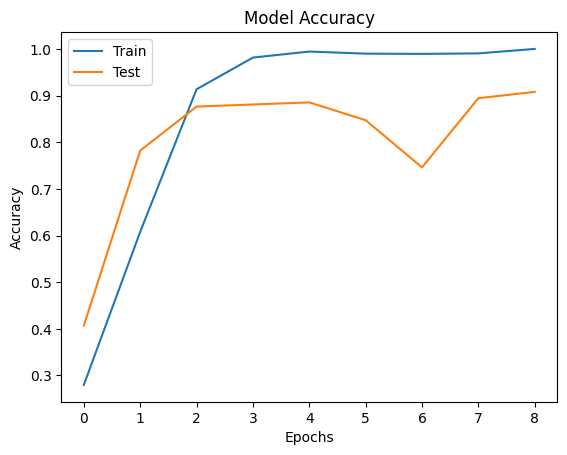

In [25]:
# Plot accuracy model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

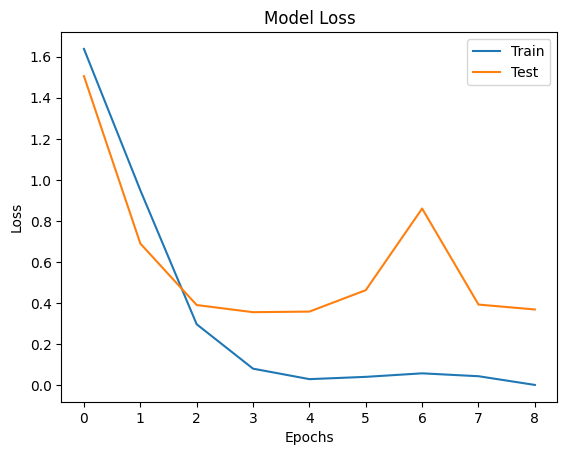

In [26]:
# Plot loss model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()